<a href="https://colab.research.google.com/github/Ranjansrb/dart/blob/main/payment_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings, copy
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tabulate import tabulate
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
init_notebook_mode(connected=True)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
onlinefraud = pd.read_csv("/content/drive/MyDrive/payment.csv")
print(onlinefraud.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [ ]:
onlinefraud.describe().round(3)
onlinefraud.info()
onlinefraud.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
fraud_min_max = [
    ['amount', onlinefraud.amount.min(), onlinefraud.amount.max()],
    ['oldbalanceOrg', onlinefraud.oldbalanceOrg.min(), onlinefraud.oldbalanceOrg.max()],
    ['newbalanceOrig', onlinefraud.newbalanceOrig.min(), onlinefraud.newbalanceOrig.max()],
    ['oldbalanceDest', onlinefraud.oldbalanceDest.min(), onlinefraud.oldbalanceDest.max()],
    ['isFraud', onlinefraud.isFraud.min(), onlinefraud.isFraud.max()]
]

print(
    tabulate(
        fraud_min_max,
        headers=['columns', 'min value', 'max value'],
        showindex=True,
        tablefmt='orgtbl',
        numalign='right'
    )
)

|    | columns        |   min value |   max value |
|----+----------------+-------------+-------------|
|  0 | amount         |           0 | 9.24455e+07 |
|  1 | oldbalanceOrg  |           0 |  5.9585e+07 |
|  2 | newbalanceOrig |           0 |  4.9585e+07 |
|  3 | oldbalanceDest |           0 | 3.56016e+08 |
|  4 | isFraud        |           0 |           1 |


In [ ]:
# Downcast numerical columns with smaller dtype

df = onlinefraud
for col in onlinefraud.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

# Use category dtype for categorical column
df['type'] = df['type'].astype('category')

In [ ]:
# Check duplicate values
df.duplicated().sum()

0

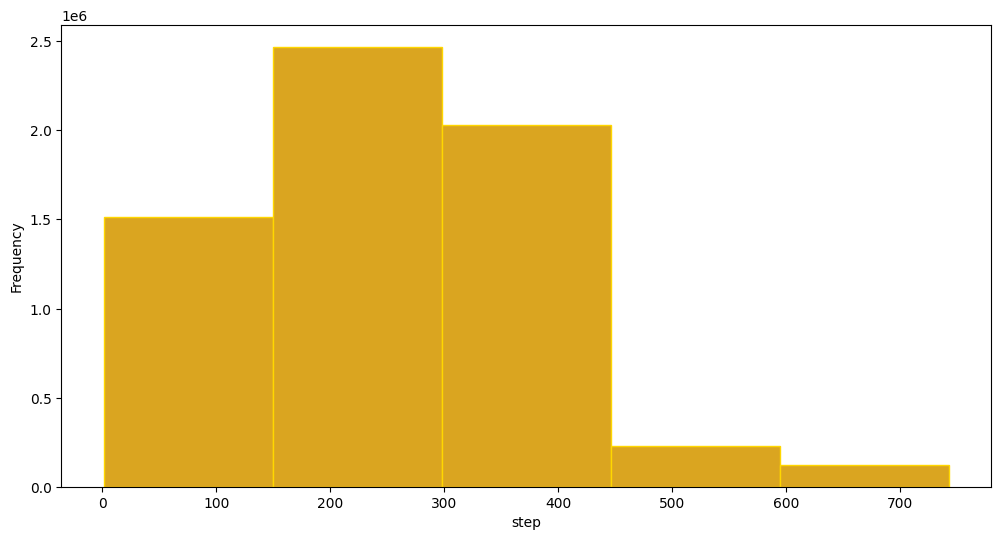

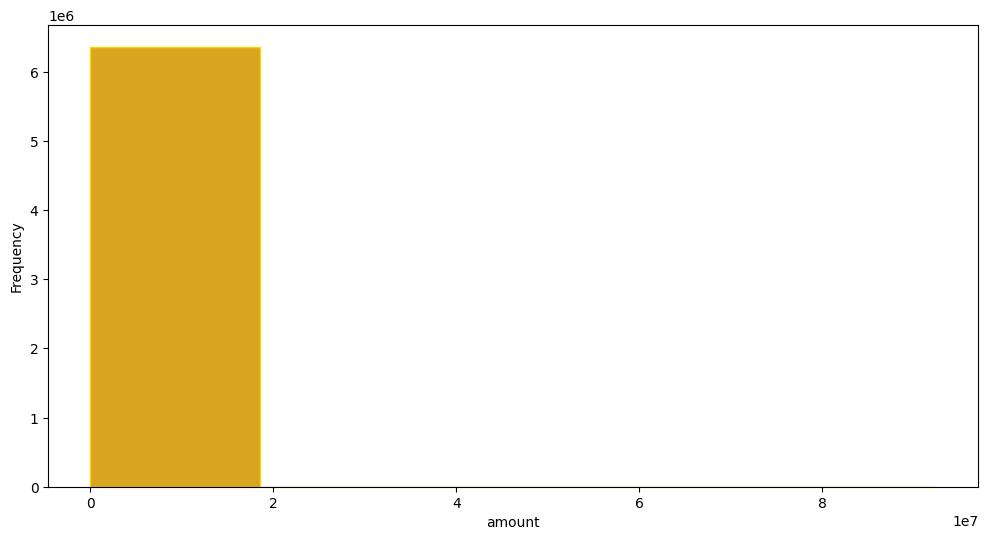

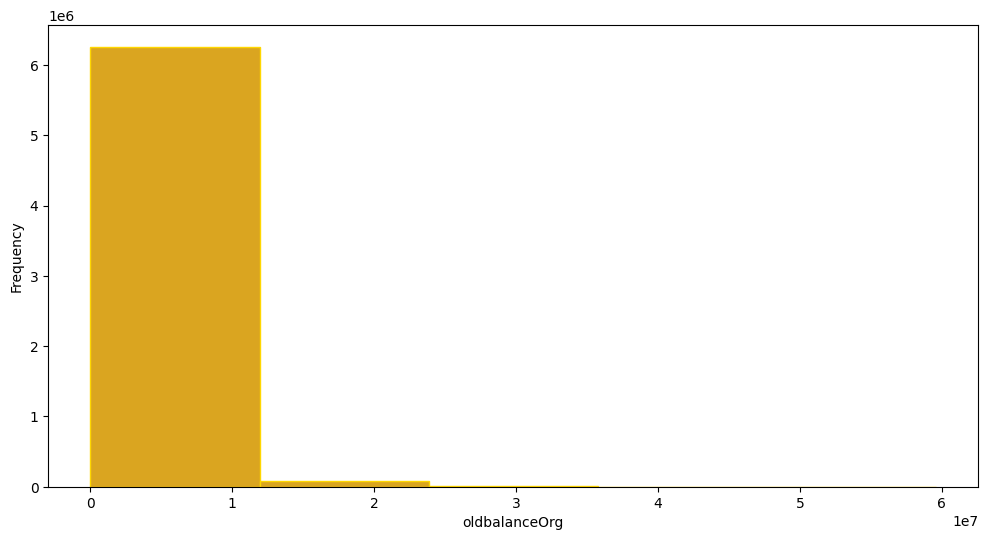

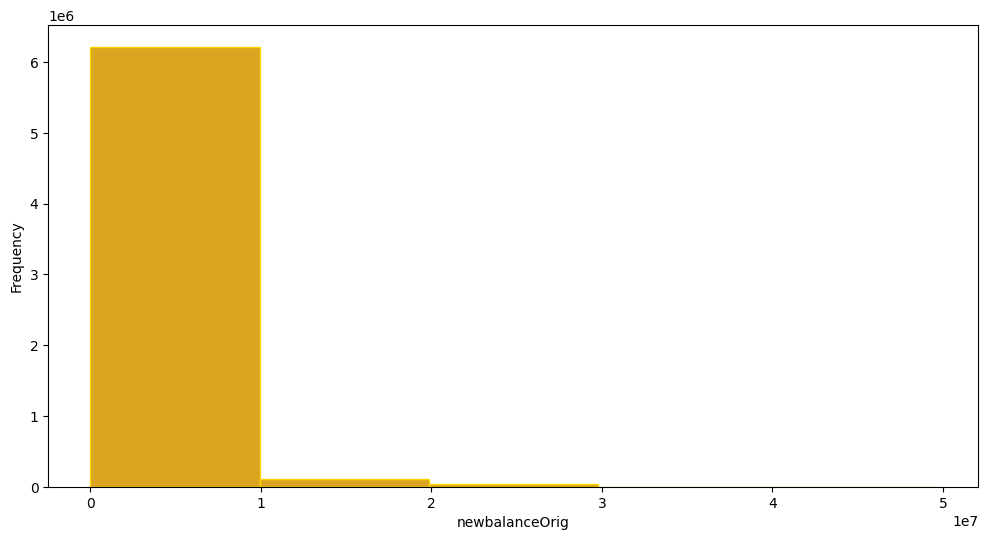

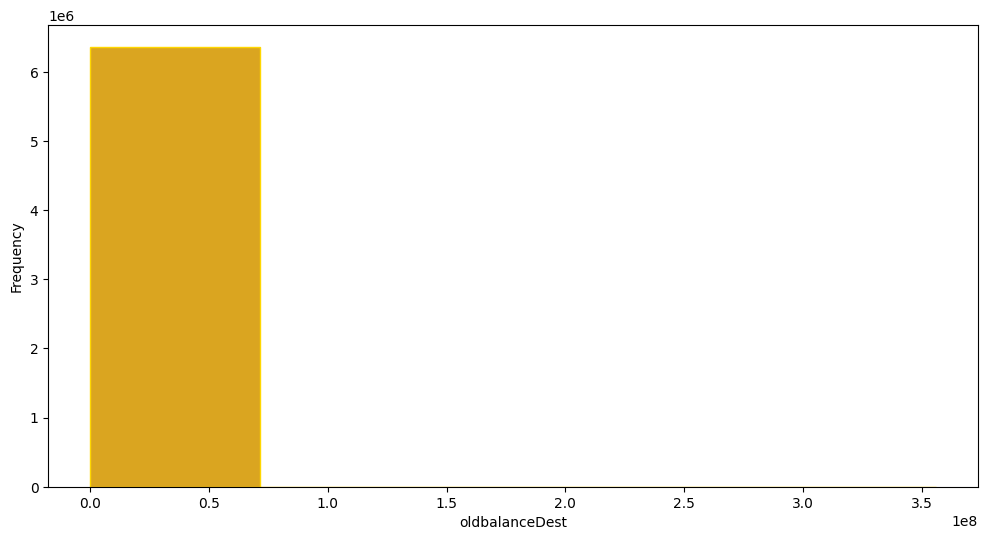

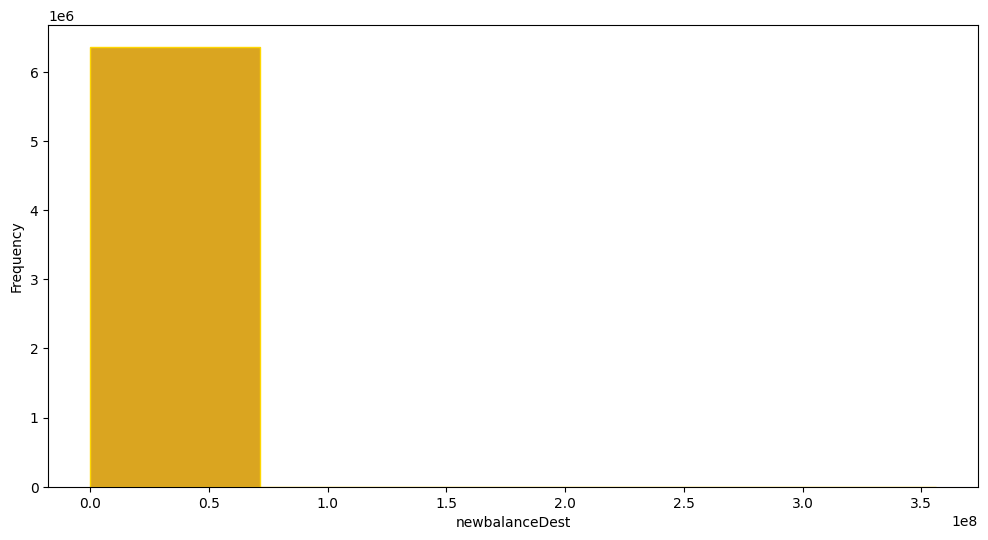

In [ ]:
%matplotlib inline

feature=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in feature:
    plt.xlabel(i)
    df[i].plot(kind='hist', bins=5, figsize=(12,6), facecolor='goldenrod',edgecolor='gold')
    plt.show()

In [ ]:
feature=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in feature:
    print(i)
    print(df[i].quantile(0.10))
    print(df[i].quantile(0.90))

    print('\n')

amount
4501.3
365423.30900000007


oldbalanceOrg
0.0
1822508.289000007


newbalanceOrig
0.0
1970344.7930000005


oldbalanceDest
0.0
2914266.6690000016


newbalanceDest
0.0
3194869.671000002




In [ ]:
feature=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in feature:
    lower = df[i].quantile(0.10)
    upper = df[i].quantile(0.90)
    df[i] = np.where(df[i] <lower, lower,df[i])
    df[i] = np.where(df[i] >upper, upper,df[i])
    print('Feature: ',i)
    print('Skewness value: ',df[i].skew())
    print('\n')

Feature:  amount
Skewness value:  0.8046460444556197


Feature:  oldbalanceOrg
Skewness value:  2.249361299814406


Feature:  newbalanceOrig
Skewness value:  2.2262847493216786


Feature:  oldbalanceDest
Skewness value:  1.4173123924260833


Feature:  newbalanceDest
Skewness value:  1.3593024983493058




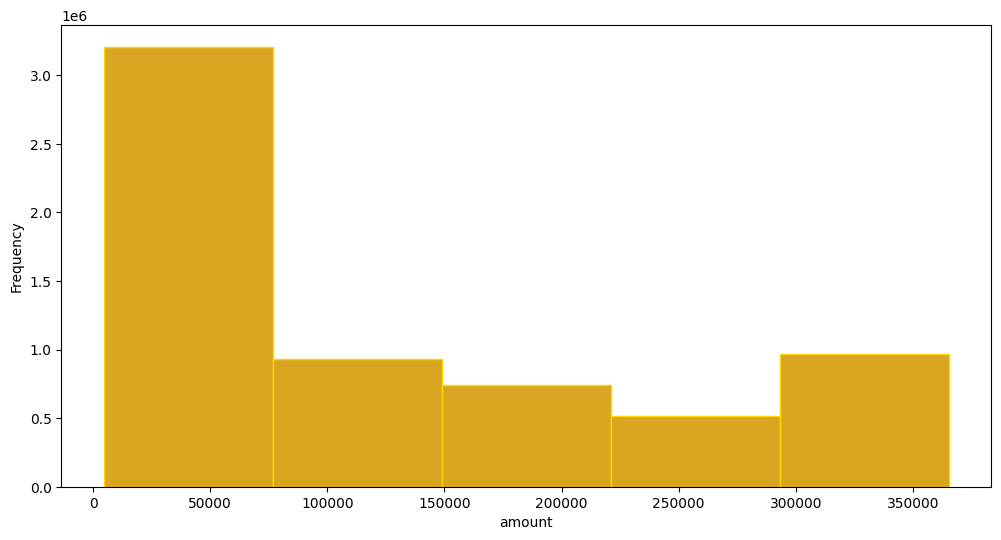

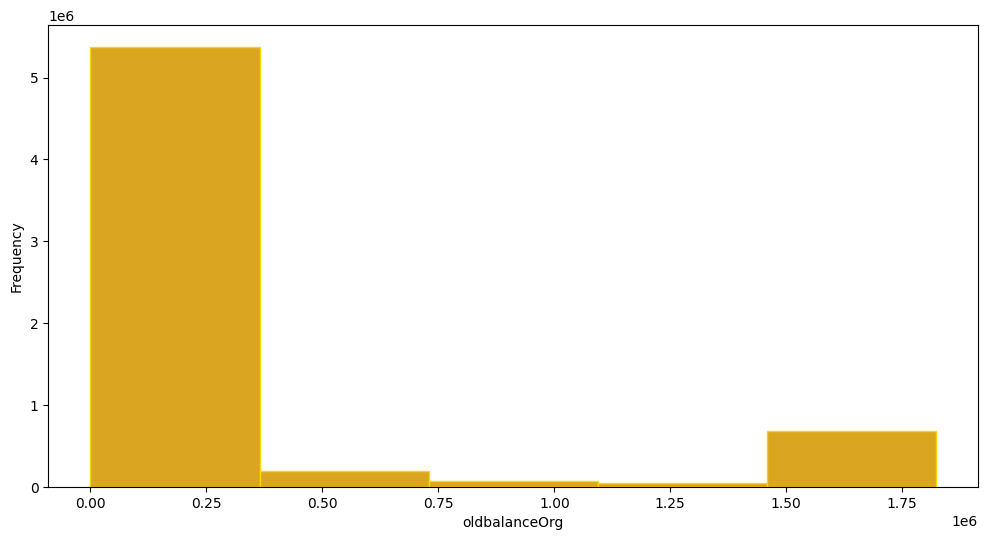

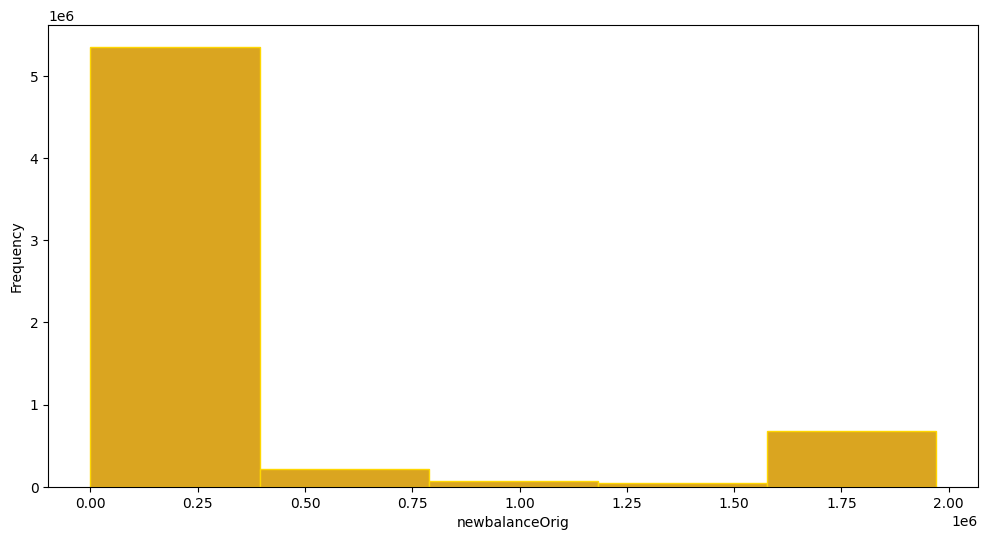

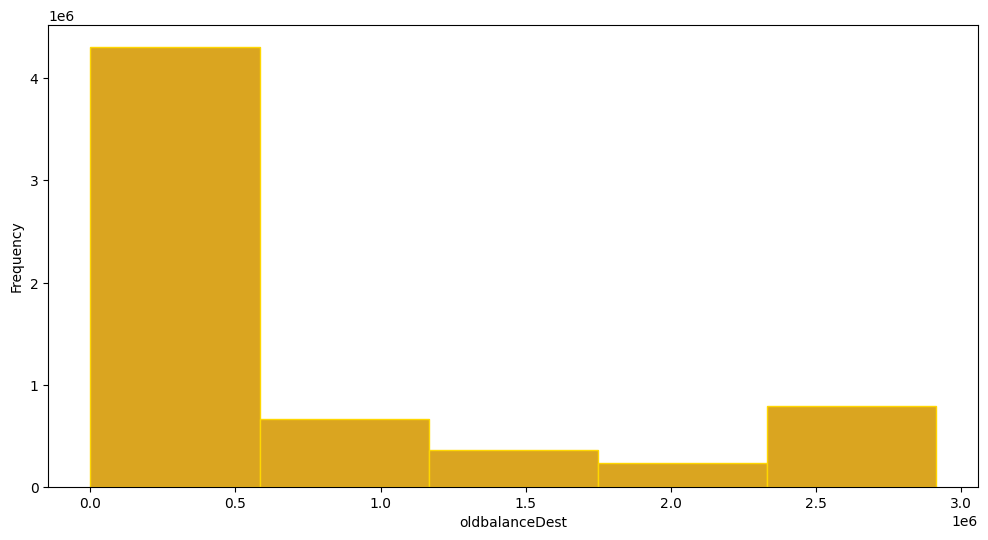

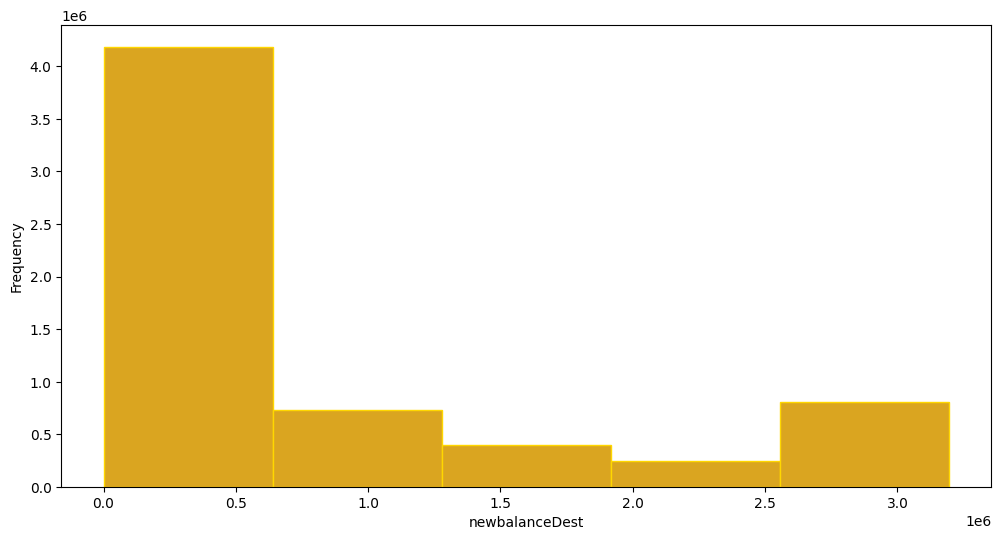

In [ ]:
feature=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in feature:
    plt.xlabel(i)
    df[i].plot(kind='hist', bins=5, figsize=(12,6), facecolor='goldenrod',edgecolor='gold')
    plt.show()

In [ ]:
df.type

0           PAYMENT
1           PAYMENT
2          TRANSFER
3          CASH_OUT
4           PAYMENT
             ...   
6362615    CASH_OUT
6362616    TRANSFER
6362617    CASH_OUT
6362618    TRANSFER
6362619    CASH_OUT
Name: type, Length: 6362620, dtype: category
Categories (5, object): ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

In [ ]:
df.type.unique()

['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']
Categories (5, object): ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

In [ ]:
payment = df.type.value_counts()
payment

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

<Axes: >

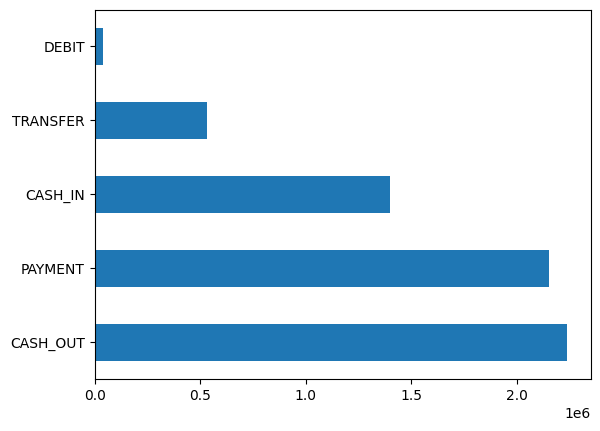

In [ ]:
payment.plot(kind='barh')

<Axes: xlabel='type', ylabel='count'>

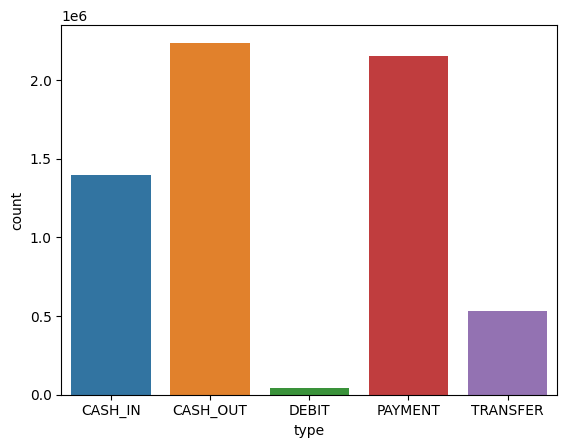

In [ ]:
sns.countplot(x='type', data=df)

In [ ]:
CrosstabResult=pd.crosstab(index=df.type,columns=df.isFraud)
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [ ]:
#with fraud happened type
CrosstabResult[1]

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: 1, dtype: int64

<Axes: xlabel='type'>

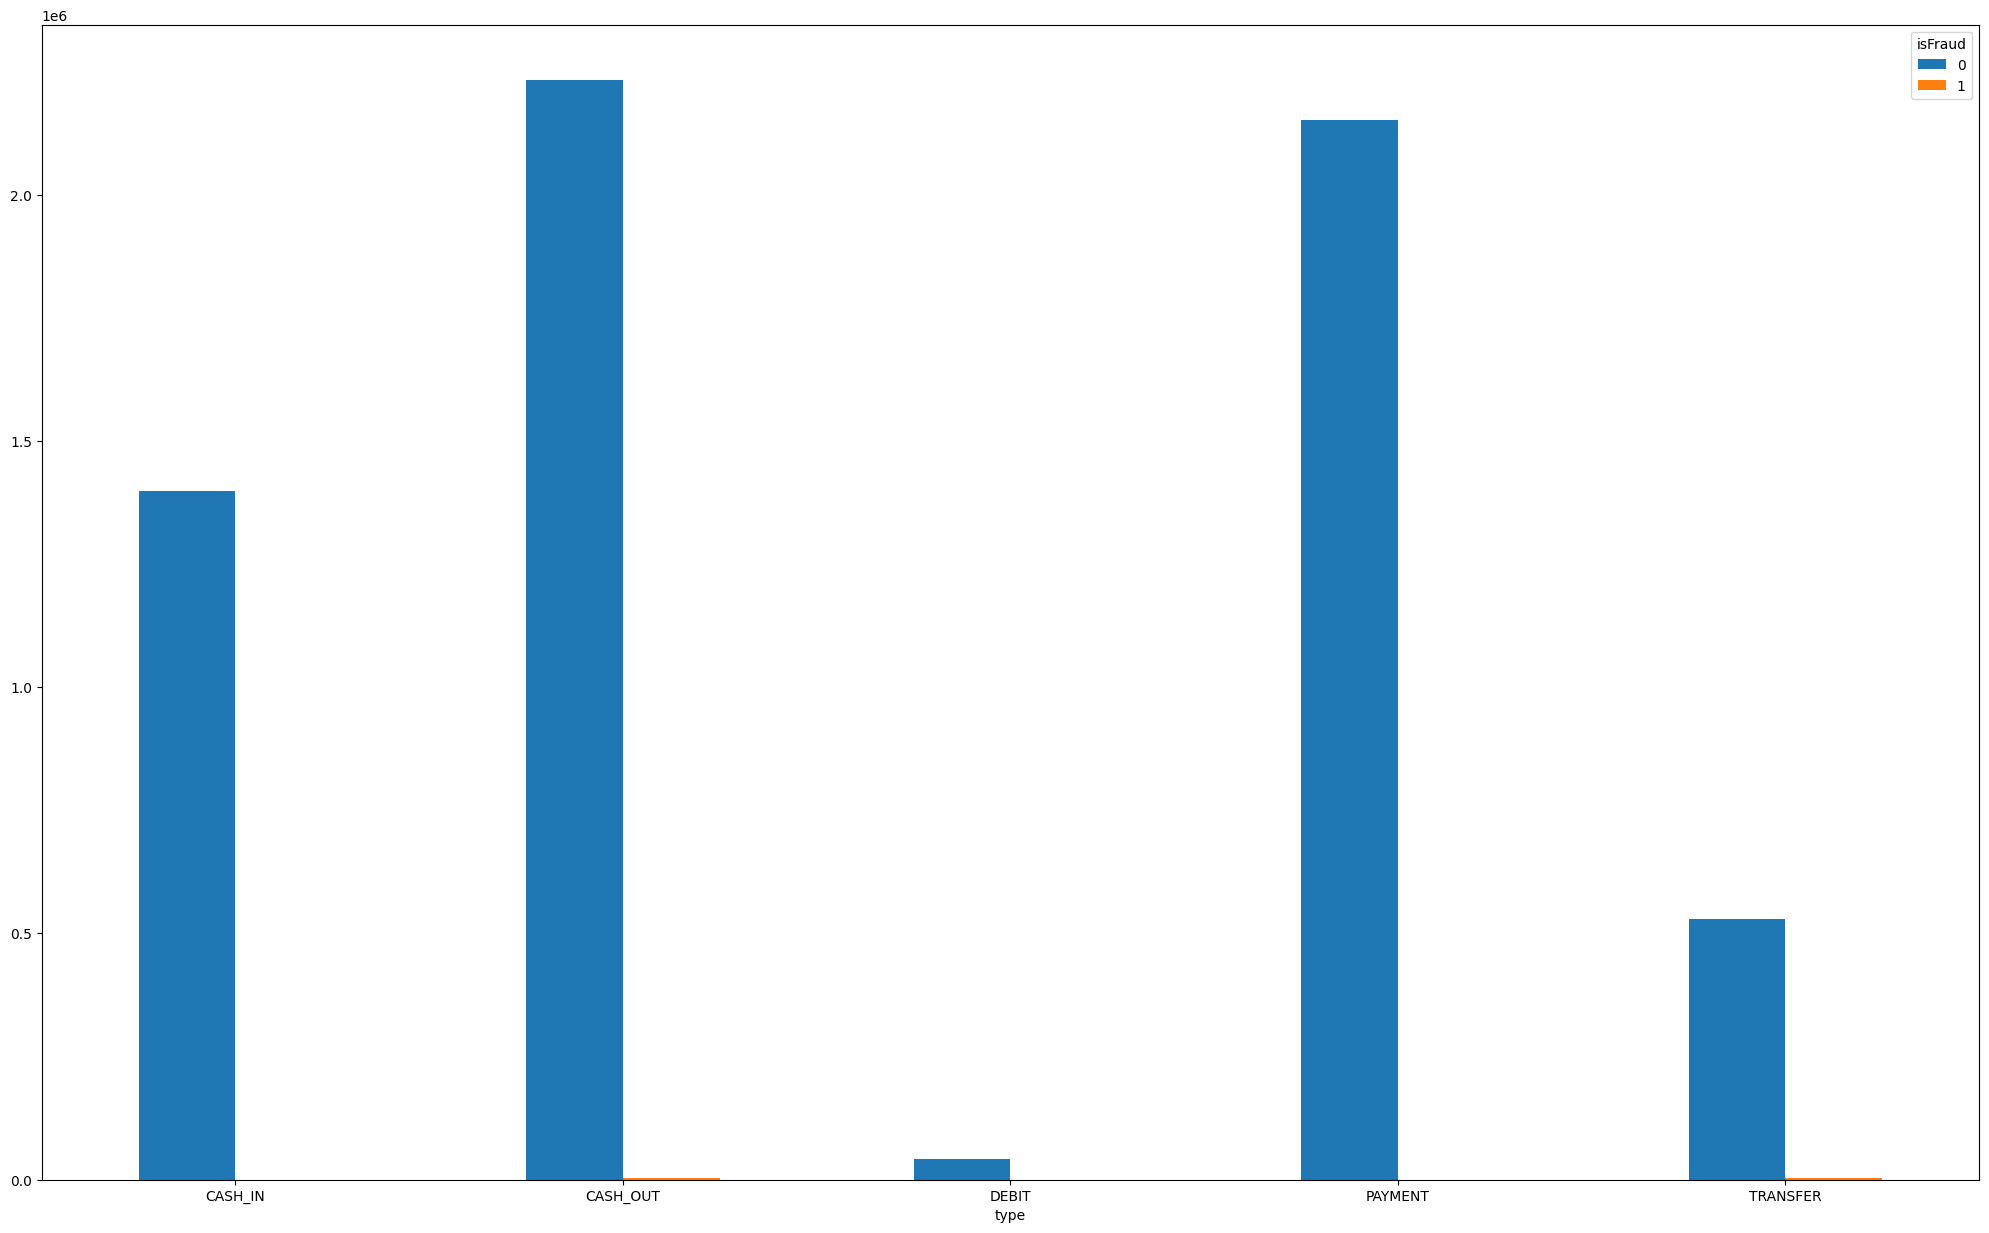

In [ ]:
# Grouped bar chart between TYPE and ISFRAUD
CrosstabResult.plot.bar(figsize=(25,15), rot=0)

<Axes: xlabel='type'>

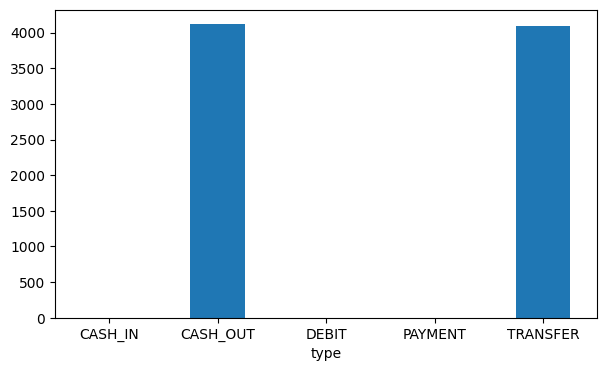

In [ ]:
# Grouped bar chart between TYPE and ISFRAUD with maximizing
CrosstabResult[1].plot.bar(figsize=(7,4), rot=0)

(3500.0, 7000.0)

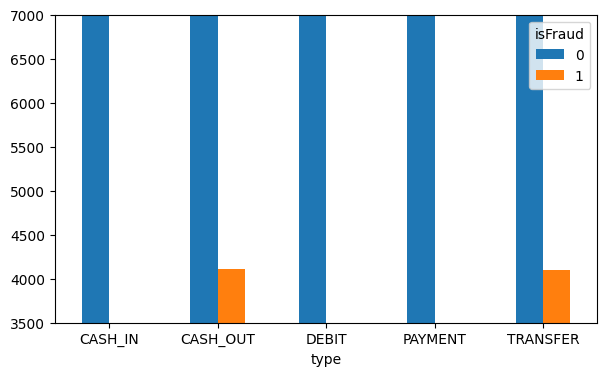

In [ ]:
# Grouped bar chart between TYPE and ISFRAUD by changing ylimit to view isFraud values
CrosstabResult.plot.bar(figsize=(7,4), rot=0)
plt.ylim([3500, 7000])

In [ ]:
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [ ]:
cashout=2233384+4116
cashout_fraud= 4116/(cashout) * 100
cashout_fraud

0.18395530726256984

In [ ]:
transfer= 528812+4097
transfer_fraud = 4097/(transfer) * 100
transfer_fraud

0.7687991758442811

In [ ]:
df.amount

0            9839.640
1            4501.300
2            4501.300
3            4501.300
4           11668.140
              ...    
6362615    339682.130
6362616    365423.309
6362617    365423.309
6362618    365423.309
6362619    365423.309
Name: amount, Length: 6362620, dtype: float64

<Axes: ylabel='amount'>

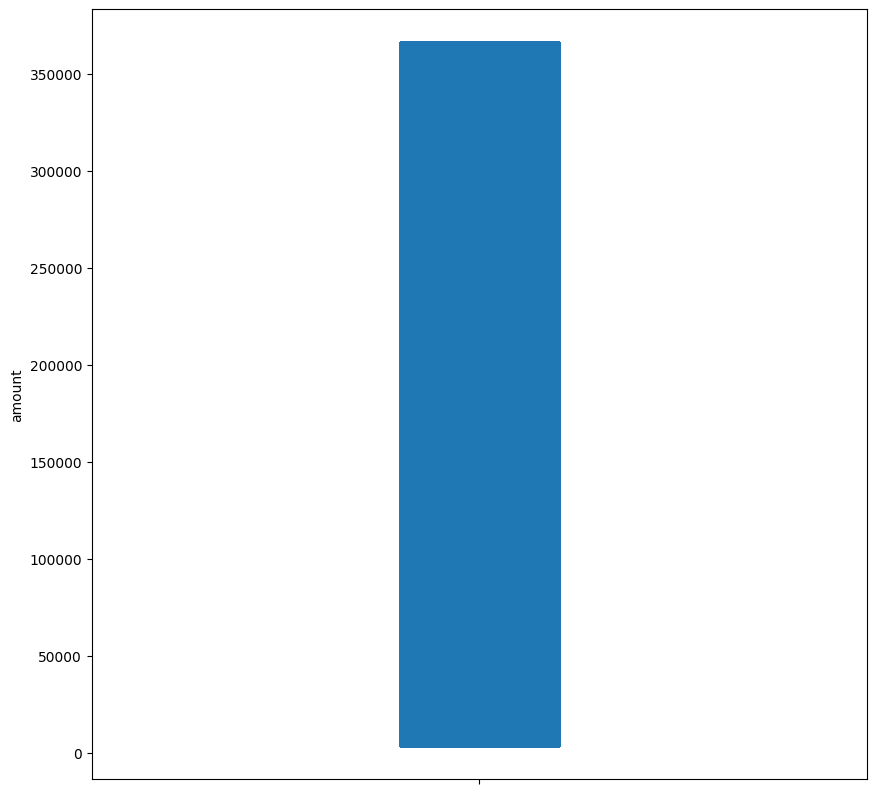

In [ ]:
plt.figure(figsize=(10,10))
sns.stripplot(y=df.amount)

In [ ]:
print('Minimum: ',df.amount.min())
print('Maximum: ',df.amount.max())

Minimum:  4501.3
Maximum:  365423.30900000007


<Axes: title={'center': 'amount'}, xlabel='isFraud'>

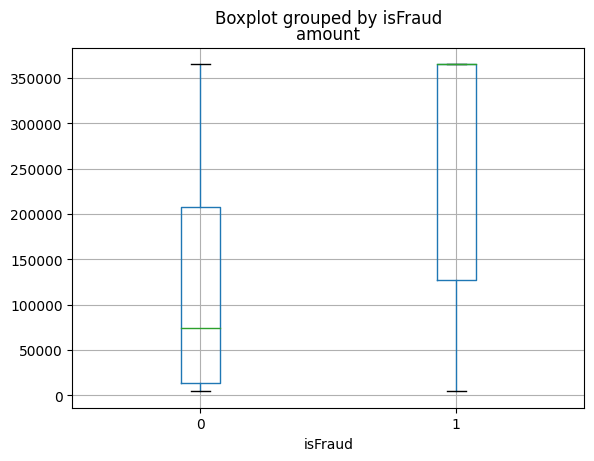

In [ ]:
df.boxplot(column='amount', by='isFraud')

In [ ]:
df.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [ ]:
flagged_fraud_records = df[(df.isFraud==1) & (df.isFlaggedFraud==1)]
flagged_fraud_records

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,365423.309,C728984460,1822508.289,1970344.793,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,365423.309,C1100582606,1343002.080,1343002.080,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,365423.309,C1035541766,536624.410,536624.410,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,365423.309,C908544136,1822508.289,1970344.793,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,365423.309,C689608084,1822508.289,1970344.793,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,365423.309,C452586515,1822508.289,1970344.793,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,365423.309,C193696150,1822508.289,1970344.793,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.220,C1684585475,353874.220,353874.220,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,365423.309,C786455622,1822508.289,1970344.793,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,365423.309,C19004745,1822508.289,1970344.793,C1806199534,0.0,0.0,1,1


In [ ]:
flagged_fraud_records.shape

(16, 11)

In [ ]:
total_fraud= df[df.isFraud ==1]
total_fraud = total_fraud.shape[0]
total_fraud

8213

In [ ]:
total_isflaggedFraud= flagged_fraud_records.shape[0]
total_isflaggedFraud

16

In [ ]:
flagged_percent = total_isflaggedFraud/total_fraud * 100
print('Percentage of flagged fraud: ',round(flagged_percent,3))

unflagged_percent= (total_fraud-total_isflaggedFraud)/total_fraud * 100
print('Percentage of incorrectly flagged fraud: ',round(unflagged_percent,3))

Percentage of flagged fraud:  0.195
Percentage of incorrectly flagged fraud:  99.805


In [ ]:
total_transactions = df.shape[0]

fraud_transaction = df[df.isFraud==1].shape[0]

fraud_percent= fraud_transaction/total_transactions * 100
fraud_percent

0.12908204481801522

In [ ]:
print('Total transactions: ',total_transactions)
print('Total fraud transactions happened: ',fraud_transaction)
print("Total fraud transaction percent: ",round(fraud_percent,2))

Total transactions:  6362620
Total fraud transactions happened:  8213
Total fraud transaction percent:  0.13


In [ ]:
fraud_amount= df[df.isFraud==1]
fraud_amount=fraud_amount.sort_values(by=['amount'],ascending=False)
fraud_amount

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5188057,367,CASH_OUT,365423.309,C1210833971,435867.160,0.000,C363013236,186826.40,622693.550,1,0
5990227,416,CASH_OUT,365423.309,C2110305720,1822508.289,0.000,C225008798,523626.59,3194869.671,1,0
5990225,416,CASH_OUT,365423.309,C246726057,1822508.289,0.000,C1786144514,2423749.18,3194869.671,1,0
5990224,416,TRANSFER,365423.309,C298387535,1822508.289,1970344.793,C662194461,0.00,0.000,1,0
5988262,415,CASH_OUT,365423.309,C2137951962,1675153.280,0.000,C309573869,12832.26,1687985.530,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6002113,428,CASH_OUT,4501.300,C1838531308,3037.670,0.000,C505532836,800854.71,803892.380,1,0
6002112,428,TRANSFER,4501.300,C1408814433,3037.670,0.000,C944070846,0.00,0.000,1,0
1796322,162,TRANSFER,4501.300,C1172437299,151.000,0.000,C315826176,0.00,0.000,1,0
1796323,162,CASH_OUT,4501.300,C790340353,151.000,0.000,C517676411,386163.34,386314.340,1,0


<Axes: ylabel='Frequency'>

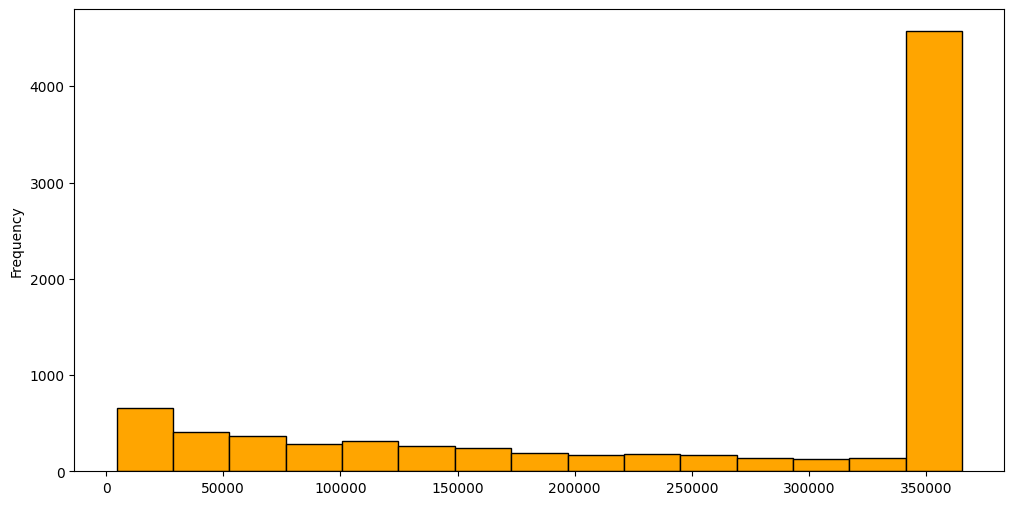

In [ ]:
fraud_amount.amount.plot(kind='hist', bins=15, figsize=(12,6), facecolor='orange',edgecolor='black')

In [ ]:
fraudster= df.nameDest.value_counts()
fraudster

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

In [ ]:
fraudster[:10]

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: nameDest, dtype: int64

<Axes: >

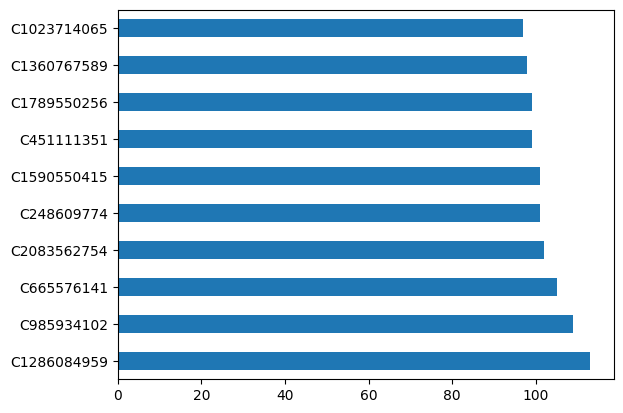

In [ ]:
fraudster[:10].plot(kind='barh')

<Axes: xlabel='step', ylabel='Density'>

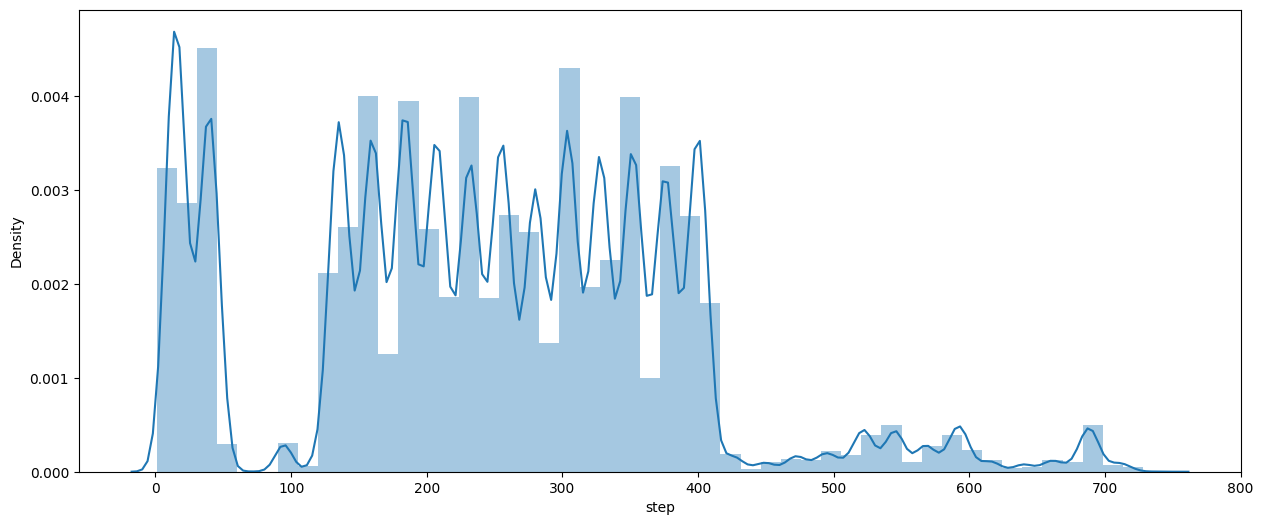

In [ ]:
plt.figure(figsize=(15, 6))
sns.distplot(df['step'], bins=50)

<Axes: >

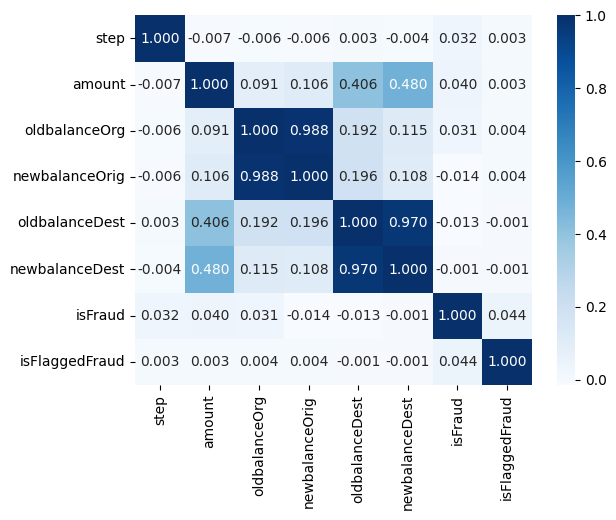

In [ ]:
# calculate correlation matrix
corr = df.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='Blues' ,fmt=".3f")

In [ ]:
onlinefraud['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
legit_txns = onlinefraud[onlinefraud.isFraud == 0]
fraud_txns = onlinefraud[onlinefraud.isFraud == 1]

In [ ]:
print(legit_txns.shape)
print(fraud_txns.shape)

(6354407, 11)
(8213, 11)


In [ ]:
legit_txns.amount.describe()

count    6.354407e+06
mean     1.224220e+05
std      1.240375e+05
min      4.501300e+03
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      3.654233e+05
Name: amount, dtype: float64

In [ ]:
fraud_txns.amount.describe()

count      8213.000000
mean     259417.430392
std      134356.752394
min        4501.300000
25%      127091.330000
50%      365423.309000
75%      365423.309000
max      365423.309000
Name: amount, dtype: float64

In [ ]:
onlinefraud.groupby('isFraud').mean()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
isFraud,,,,,,,
0,243.235663,122422.010691,257917.538371,279612.943348,662716.979254,759804.754429,0.000000
1,368.413856,259417.430392,742573.107241,34911.538479,312655.550632,736134.126598,0.001948


In [ ]:
legit_sample = legit_txns.sample(n=8213) # Samples 8213 transactions out of the legit transactions

undersampled_dataset = pd.concat([legit_sample, fraud_txns], axis=0) # Concatenates all the 8213 the fraud_txns and the 8213 samples of the legit txns

In [ ]:
undersampled_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1835742,163,CASH_IN,165427.77,C1998145761,12041.0,177468.77,C1341718010,47719.01,0.00,0,0
6223285,590,PAYMENT,9156.45,C9056618,696.0,0.00,M1788065789,0.00,0.00,0,0
3089445,235,CASH_IN,274374.34,C740467963,9968.0,284342.34,C909378045,165941.52,0.00,0,0
4420857,322,PAYMENT,75259.64,C1249320009,0.0,0.00,M2104307201,0.00,0.00,0,0
1915697,166,CASH_OUT,80084.67,C1706569207,2003.0,0.00,C1153650642,130157.45,210242.12,0,0


In [ ]:
undersampled_dataset.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.130,C786484425,339682.130,0.0,C776919290,0.000,339682.130,1,0
6362616,743,TRANSFER,365423.309,C1529008245,1822508.289,0.0,C1881841831,0.000,0.000,1,0
6362617,743,CASH_OUT,365423.309,C1162922333,1822508.289,0.0,C1365125890,68488.840,3194869.671,1,0
6362618,743,TRANSFER,365423.309,C1685995037,850002.520,0.0,C2080388513,0.000,0.000,1,0
6362619,743,CASH_OUT,365423.309,C1280323807,850002.520,0.0,C873221189,2914266.669,3194869.671,1,0


In [ ]:
undersampled_dataset['isFraud'].value_counts()

0    8213
1    8213
Name: isFraud, dtype: int64

In [ ]:
undersampled_dataset.groupby('isFraud').mean()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
isFraud,,,,,,,
0,244.266285,123072.269360,256553.736374,279091.250516,654952.241024,754399.759954,0.000000
1,368.413856,259417.430392,742573.107241,34911.538479,312655.550632,736134.126598,0.001948


In [ ]:
onlinefraud.groupby('isFraud').mean()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
isFraud,,,,,,,
0,243.235663,122422.010691,257917.538371,279612.943348,662716.979254,759804.754429,0.000000
1,368.413856,259417.430392,742573.107241,34911.538479,312655.550632,736134.126598,0.001948


In [ ]:
X = undersampled_dataset.drop(columns=['isFraud','type','nameDest','nameOrig'], axis=1)
# Remove the class column from the undersampled dataset
print(X)

         step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
1835742   163  165427.770      12041.000       177468.77       47719.010   
6223285   590    9156.450        696.000            0.00           0.000   
3089445   235  274374.340       9968.000       284342.34      165941.520   
4420857   322   75259.640          0.000            0.00           0.000   
1915697   166   80084.670       2003.000            0.00      130157.450   
...       ...         ...            ...             ...             ...   
6362615   743  339682.130     339682.130            0.00           0.000   
6362616   743  365423.309    1822508.289            0.00           0.000   
6362617   743  365423.309    1822508.289            0.00       68488.840   
6362618   743  365423.309     850002.520            0.00           0.000   
6362619   743  365423.309     850002.520            0.00     2914266.669   

         newbalanceDest  isFlaggedFraud  
1835742           0.000               0  
622

In [ ]:
Y = undersampled_dataset['isFraud']
print(Y)

1835742    0
6223285    0
3089445    0
4420857    0
1915697    0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 16426, dtype: uint8


In [ ]:
X_train_undersampled, X_test_undersampled, Y_train_undersampled, Y_test_undersampled = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
# parameters test_size means testing data should consist of only 20% of the transactions randomly out of the provided X and Y datasets
# stratify=Y means if For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=Y will make sure that your random split has 25% of 0's and 75% of 1's.
# random_state controls the randomness, it will be producing the similar results independent of the number of executions.

In [ ]:
print(X.shape, X_train_undersampled.shape, X_test_undersampled.shape)

(16426, 7) (13140, 7) (3286, 7)


In [ ]:
X = onlinefraud.drop(columns=['isFraud','type','nameDest','nameOrig'], axis=1)
# Remove the class column from the main dataset
print(X)

         step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0           1    9839.640     170136.000       160296.36           0.000   
1           1    4501.300      21249.000        19384.72           0.000   
2           1    4501.300        181.000            0.00           0.000   
3           1    4501.300        181.000            0.00       21182.000   
4           1   11668.140      41554.000        29885.86           0.000   
...       ...         ...            ...             ...             ...   
6362615   743  339682.130     339682.130            0.00           0.000   
6362616   743  365423.309    1822508.289            0.00           0.000   
6362617   743  365423.309    1822508.289            0.00       68488.840   
6362618   743  365423.309     850002.520            0.00           0.000   
6362619   743  365423.309     850002.520            0.00     2914266.669   

         newbalanceDest  isFlaggedFraud  
0                 0.000               0  
1  

In [ ]:
Y = onlinefraud['isFraud']
print(Y)

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: uint8


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
# parameters test_size means testing data should consist of only 20% of the transactions randomly out of the provided X and Y datasets
# stratify=Y means if For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=Y will make sure that your random split has 25% of 0's and 75% of 1's.
# random_state controls the randomness, it will be producing the similar results independent of the number of executions.

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(6362620, 7) (5090096, 7) (1272524, 7)


In [ ]:
from imblearn.over_sampling import SMOTE
#SMOTE = synthetic minority oversampling technique
smote = SMOTE() # create SMOTE Object

In [ ]:
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
print(X_train_smote.shape)
print(Y_train_smote.shape)

(10167052, 7)
(10167052,)


In [ ]:
from imblearn.over_sampling import ADASYN #ADASYN = Adaptive Synthetic Sampling
adasyn = ADASYN(sampling_strategy='not majority', random_state=2) # create ADASYN Object

In [ ]:
X_train_adasyn, Y_train_adasyn = adasyn.fit_resample(X_train, Y_train)
print(X_train_adasyn.shape)
print(Y_train_adasyn.shape)

(10166862, 7)
(10166862,)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state = 2)

In [ ]:
X_train_ros, Y_train_ros = ros.fit_resample(X_train, Y_train)
print(X_train_ros.shape)
print(Y_train_ros.shape)

(10167052, 7)
(10167052,)


In [ ]:
scaler = StandardScaler()
X_train_scaled_undersampled = scaler.fit_transform(X_train_undersampled)
X_test_scaled_undersampled = scaler.transform(X_test_undersampled)

In [ ]:
X_train_scaled_smote = scaler.fit_transform(X_train_smote) # smote training data
X_train_scaled_adasyn = scaler.fit_transform(X_train_adasyn) # adasyn training data

X_train_scaled_ros = scaler.fit_transform(X_train_ros) # ros training data

X_test_scaled = scaler.transform(X_test) # original testing data

In [ ]:
LogisticRegressionModel = LogisticRegression()

In [ ]:
SVM_SVC_Model_CLF = SVC(kernel='linear')

In [ ]:
NaiveBayes_Model_CLF = GaussianNB()

In [ ]:
KNN_Model_CLF = KNeighborsClassifier(n_neighbors=5)

In [ ]:
DecisionTree_Model = DecisionTreeClassifier()
params = {'max_depth': [2, 4, 6, 8, 10],
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 2, 3, 4, 5]}
DecisionTree_GridSearch_CLF = GridSearchCV(DecisionTree_Model, params, cv=5)

In [ ]:
LogisticRegressionModel.fit(X_train_scaled_undersampled, Y_train_undersampled)

LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = LogisticRegressionModel.predict(X_train_scaled_undersampled)
LR_undersampling_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_undersampled)
print('Accuracy on Training data : ', LR_undersampling_training_data_accuracy)
LR_undersampling_training_data_classification_report = classification_report(X_train_prediction, Y_train_undersampled)
print('\nClassification Report on Training data : \n', LR_undersampling_training_data_classification_report)

Accuracy on Training data :  0.9029680365296804

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.96      0.86      0.91      7317
           1       0.85      0.95      0.90      5823

    accuracy                           0.90     13140
   macro avg       0.90      0.91      0.90     13140
weighted avg       0.91      0.90      0.90     13140



In [ ]:
# accuracy on test data
X_test_prediction = LogisticRegressionModel.predict(X_test_scaled_undersampled)
LR_undersampling_test_data_accuracy = accuracy_score(X_test_prediction, Y_test_undersampled)
print('Accuracy score on Test Data : ', LR_undersampling_test_data_accuracy)
LR_undersampling_testing_data_classification_report = classification_report(X_test_prediction, Y_test_undersampled)
print('\nClassification Report on Training data : \n', LR_undersampling_testing_data_classification_report)

Accuracy score on Test Data :  0.904138770541692

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      1812
           1       0.85      0.95      0.90      1474

    accuracy                           0.90      3286
   macro avg       0.90      0.91      0.90      3286
weighted avg       0.91      0.90      0.90      3286



In [ ]:
LogisticRegressionModel.fit(X_train_scaled_smote, Y_train_smote)

LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = LogisticRegressionModel.predict(X_train_scaled_smote)
LR_smote_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_smote)
print('Accuracy on Training data : ', LR_smote_training_data_accuracy)
LR_smote_training_data_classification_report = classification_report(X_train_prediction, Y_train_smote)
print('\nClassification Report on Training data : \n', LR_smote_training_data_classification_report)

Accuracy on Training data :  0.9053125724152882

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.95      0.87      0.91   5553738
           1       0.86      0.95      0.90   4613314

    accuracy                           0.91  10167052
   macro avg       0.91      0.91      0.91  10167052
weighted avg       0.91      0.91      0.91  10167052



In [ ]:
# accuracy on test data
X_test_prediction = LogisticRegressionModel.predict(X_test_scaled)
LR_smote_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', LR_smote_test_data_accuracy)
LR_smote_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', LR_smote_testing_data_classification_report)

Accuracy score on Test Data :  0.9532692507174717

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98   1211895
           1       0.85      0.02      0.05     60629

    accuracy                           0.95   1272524
   macro avg       0.90      0.51      0.51   1272524
weighted avg       0.95      0.95      0.93   1272524



In [ ]:
LogisticRegressionModel.fit(X_train_scaled_adasyn, Y_train_adasyn)

LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = LogisticRegressionModel.predict(X_train_scaled_adasyn)
LR_adasyn_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_adasyn)
print('Accuracy on Training data : ', LR_adasyn_training_data_accuracy)
LR_adasyn_training_data_classification_report = classification_report(X_train_prediction, Y_train_adasyn)
print('\nClassification Report on Training data : \n', LR_adasyn_training_data_classification_report)

Accuracy on Training data :  0.9099704510595304

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91   5051898
           1       0.91      0.91      0.91   5114964

    accuracy                           0.91  10166862
   macro avg       0.91      0.91      0.91  10166862
weighted avg       0.91      0.91      0.91  10166862



In [ ]:
# accuracy on test data
X_test_prediction = LogisticRegressionModel.predict(X_test_scaled)
LR_adasyn_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', LR_adasyn_test_data_accuracy)
LR_adasyn_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', LR_adasyn_testing_data_classification_report)

Accuracy score on Test Data :  0.9981642782375814

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270181
           1       0.50      0.35      0.41      2343

    accuracy                           1.00   1272524
   macro avg       0.75      0.68      0.71   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
LogisticRegressionModel.fit(X_train_scaled_ros, Y_train_ros)

LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = LogisticRegressionModel.predict(X_train_scaled_ros)
LR_ros_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_ros)
print('Accuracy on Training data : ', LR_ros_training_data_accuracy)
LR_ros_training_data_classification_report = classification_report(X_train_prediction, Y_train_ros)
print('\nClassification Report on Training data : \n', LR_ros_training_data_classification_report)

Accuracy on Training data :  0.9052604432435282

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.96      0.87      0.91   5602438
           1       0.85      0.95      0.90   4564614

    accuracy                           0.91  10167052
   macro avg       0.91      0.91      0.91  10167052
weighted avg       0.91      0.91      0.91  10167052



In [ ]:
# accuracy on test data
X_test_prediction = LogisticRegressionModel.predict(X_test_scaled)
LR_ros_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', LR_ros_test_data_accuracy)
LR_ros_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', LR_ros_testing_data_classification_report)


Accuracy score on Test Data :  0.9561257783743174

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98   1215534
           1       0.85      0.02      0.05     56990

    accuracy                           0.96   1272524
   macro avg       0.90      0.51      0.51   1272524
weighted avg       0.95      0.96      0.94   1272524



In [ ]:
DecisionTree_Model.fit(X_train_scaled_undersampled, Y_train_undersampled)

DecisionTreeClassifier()

In [ ]:
# accuracy on training data
X_train_prediction = DecisionTree_Model.predict(X_train_scaled_undersampled)
DT_undersampling_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_undersampled)
print('Accuracy on Training data : ', DT_undersampling_training_data_accuracy)
DT_undersampling_training_data_classification_report = classification_report(X_train_prediction, Y_train_undersampled)
print('\nClassification Report on Training data : \n', DT_undersampling_training_data_classification_report)

Accuracy on Training data :  1.0

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6570
           1       1.00      1.00      1.00      6570

    accuracy                           1.00     13140
   macro avg       1.00      1.00      1.00     13140
weighted avg       1.00      1.00      1.00     13140



In [ ]:
# accuracy on test data
X_test_prediction = DecisionTree_Model.predict(X_test_scaled_undersampled)
DT_undersampling_test_data_accuracy = accuracy_score(X_test_prediction, Y_test_undersampled)
print('Accuracy score on Test Data : ', DT_undersampling_test_data_accuracy)
DT_undersampling_testing_data_classification_report = classification_report(X_test_prediction, Y_test_undersampled)
print('\nClassification Report on Training data : \n', DT_undersampling_testing_data_classification_report)

Accuracy score on Test Data :  0.9850882531953743

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1638
           1       0.99      0.98      0.99      1648

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



In [ ]:
DecisionTree_Model.fit(X_train_scaled_smote, Y_train_smote)

DecisionTreeClassifier()

In [ ]:
# accuracy on training data
X_train_prediction = DecisionTree_Model.predict(X_train_scaled_smote)
DT_smote_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_smote)
print('Accuracy on Training data : ', DT_smote_training_data_accuracy)
DT_smote_training_data_classification_report = classification_report(X_train_prediction, Y_train_smote)
print('\nClassification Report on Training data : \n', DT_smote_training_data_classification_report)

Accuracy on Training data :  0.9999430513387755

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083975
           1       1.00      1.00      1.00   5083077

    accuracy                           1.00  10167052
   macro avg       1.00      1.00      1.00  10167052
weighted avg       1.00      1.00      1.00  10167052



In [ ]:
# accuracy on test data
X_test_prediction = DecisionTree_Model.predict(X_test_scaled)
DT_smote_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', DT_smote_test_data_accuracy)
DT_smote_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', DT_smote_testing_data_classification_report)

Accuracy score on Test Data :  0.9692540179988747

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98   1232092
           1       0.90      0.04      0.07     40432

    accuracy                           0.97   1272524
   macro avg       0.93      0.52      0.53   1272524
weighted avg       0.97      0.97      0.96   1272524



In [ ]:
DecisionTree_Model.fit(X_train_scaled_adasyn, Y_train_adasyn)

DecisionTreeClassifier()

In [ ]:
# accuracy on training data
X_train_prediction = DecisionTree_Model.predict(X_train_scaled_adasyn)
DT_adasyn_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_adasyn)
print('Accuracy on Training data : ', DT_adasyn_training_data_accuracy)
DT_adasyn_training_data_classification_report = classification_report(X_train_prediction, Y_train_adasyn)
print('\nClassification Report on Training data : \n', DT_adasyn_training_data_classification_report)

Accuracy on Training data :  0.9998449865848479

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5084550
           1       1.00      1.00      1.00   5082312

    accuracy                           1.00  10166862
   macro avg       1.00      1.00      1.00  10166862
weighted avg       1.00      1.00      1.00  10166862



In [ ]:
# accuracy on test data
X_test_prediction = DecisionTree_Model.predict(X_test_scaled)
DT_adasyn_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', DT_adasyn_test_data_accuracy)
DT_adasyn_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', DT_adasyn_testing_data_classification_report)

Accuracy score on Test Data :  0.9712233325265378

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99   1236326
           1       0.37      0.02      0.03     36198

    accuracy                           0.97   1272524
   macro avg       0.67      0.51      0.51   1272524
weighted avg       0.95      0.97      0.96   1272524



In [ ]:
DecisionTree_Model.fit(X_train_scaled_ros, Y_train_ros)

DecisionTreeClassifier()

In [ ]:
# accuracy on training data
X_train_prediction = DecisionTree_Model.predict(X_train_scaled_ros)
DT_ros_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_ros)
print('Accuracy on Training data : ', DT_ros_training_data_accuracy)
DT_ros_training_data_classification_report = classification_report(X_train_prediction, Y_train_ros)
print('\nClassification Report on Training data : \n', DT_ros_training_data_classification_report)

Accuracy on Training data :  0.9998382028536885

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083497
           1       1.00      1.00      1.00   5083555

    accuracy                           1.00  10167052
   macro avg       1.00      1.00      1.00  10167052
weighted avg       1.00      1.00      1.00  10167052



In [ ]:
# accuracy on test data
X_test_prediction = DecisionTree_Model.predict(X_test_scaled)
DT_ros_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', DT_ros_test_data_accuracy)
DT_ros_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', DT_ros_testing_data_classification_report)

Accuracy score on Test Data :  0.9993501104890753

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270734
           1       0.79      0.73      0.76      1790

    accuracy                           1.00   1272524
   macro avg       0.90      0.86      0.88   1272524
weighted avg       1.00      1.00      1.00   1272524

